In [461]:
import cartoframes
import pandas as pd
import geopandas as gpd


In [462]:
cc = cartoframes.CartoContext()

In [19]:
query = '''
SELECT 
  line.cartodb_id, 
  line.the_geom, 
  line.the_geom_webmercator, 
  COUNT(circle.the_geom) as count_collisions, 
  SUM(circle.number_of_persons_killed) as sum_fatalities
FROM lion_lines_nyc AS line 
JOIN nypd_collisions_2017 AS circle 
ON ST_DWithin(
  line.the_geom_webmercator, 
  circle.the_geom_webmercator, 
  30
  )
GROUP BY 
  line.cartodb_id, 
  line.the_geom, 
  line.the_geom_webmercator 
'''

In [20]:
counts = cc.query(query, table_name = 'crash_count_segment')

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/crash_count_segment


In [21]:
counts.head()

,count_collisions,sum_fatalities,the_geom
cartodb_id,,,
3,36,1,0105000020E610000001000000010200000003000000C3...
4,15,0,0105000020E6100000010000000102000000020000007E...
5,3,0,0105000020E610000001000000010200000002000000EE...
8,1,0,0105000020E6100000010000000102000000020000002B...
9,7,0,0105000020E61000000100000001020000000200000088...


In [30]:
counts.reset_index(inplace=True)

In [533]:
road_segments = cc.read('lion_lines_full', decode_geom=True)

In [31]:
road_segments.reset_index(inplace=True)

In [36]:
road_collision_count = road_segments.join(counts, on='cartodb_id', how='left', lsuffix='_left')

In [37]:
road_collision_count.shape

(119306, 39)

In [39]:
road_segments.shape

(119306, 35)

In [53]:
road_collision_count.count_collisions.fillna(value=0, inplace=True)

In [54]:
road_collision_count.sum_fatalities.fillna(value=0, inplace=True)

In [55]:
road_collision_count.shape

(119306, 39)

In [56]:
road_collision_count

,cartodb_id_left,bike_lane,bike_trafd,borocode,date_creat,date_modif,frm_lvl_co,full_stree,l_blkfc_id,l_high_hn,...,status,the_geom_left,time_creat,time_modif,to_lvl_co,trafdir,cartodb_id,count_collisions,sum_fatalities,the_geom
0,14518,None,None,4,2007-11-29,2017-03-17,13,B 149 ST,0,None,...,2,0105000020E61000000100000001020000000200000060...,00:00:00.000,00:00:00.000,13,TW,19822.0,3.0,0.0,0105000020E610000001000000010200000004000000F6...
1,22,None,None,5,2007-11-29,2017-03-17,13,SILVER CT,1622611887,60,...,2,0105000020E610000001000000010200000002000000A4...,00:00:00.000,00:00:00.000,13,TW,34.0,7.0,0.0,0105000020E610000001000000010200000002000000C9...
2,23,None,None,3,2007-11-29,2017-03-17,13,AVE W,1822602298,335,...,2,0105000020E61000000100000001020000000200000056...,00:00:00.000,00:00:00.000,13,TW,35.0,27.0,0.0,0105000020E61000000100000001020000000500000054...
3,7,None,None,2,2007-11-29,2017-03-17,13,E 181 ST,1522611738,759,...,2,0105000020E61000000100000001020000000200000012...,00:00:00.000,00:00:00.000,13,TF,15.0,4.0,0.0,0105000020E6100000010000000102000000020000006C...
4,8,None,None,4,2007-11-29,2017-03-17,13,58 LN,102264679,51-099,...,2,0105000020E6100000010000000102000000020000002B...,00:00:00.000,00:00:00.000,13,TF,18.0,3.0,0.0,0105000020E610000001000000010200000002000000DA...
5,9,None,None,4,2007-11-29,2017-03-17,13,FOREST AVE,52263275,68-099,...,2,0105000020E61000000100000001020000000200000088...,00:00:00.000,00:00:00.000,13,TW,19.0,53.0,0.0,0105000020E6100000010000000102000000020000007E...
6,10,None,None,5,2007-11-29,2017-03-17,13,TIDES LN,1722607326,0,...,2,0105000020E6100000010000000102000000020000005F...,00:00:00.000,00:00:00.000,13,TW,21.0,18.0,0.0,0105000020E610000001000000010200000004000000AB...
7,24,None,None,4,2007-11-29,2017-03-17,13,NORTHERN BL E,0,None,...,2,0105000020E6100000010000000102000000020000009E...,00:00:00.000,00:00:00.000,13,TW,36.0,8.0,0.0,0105000020E6100000010000000102000000020000006D...
8,270,None,None,3,2016-01-15,2016-02-05,13,ALLEY,2022700401,None,...,2,0105000020E6100000010000000102000000020000003B...,00:00:00.000,00:00:00.000,13,TW,370.0,11.0,0.0,0105000020E610000001000000010200000002000000BD...
9,75,None,None,2,2009-06-16,2017-03-17,13,POPHAM AVE,1522602451,None,...,2,0105000020E61000000100000001020000000200000020...,00:00:00.000,00:00:00.000,13,TF,106.0,38.0,0.0,0105000020E610000001000000010200000018000000AB...


In [463]:
collisions = cc.read('nypd_collisions_2017')

In [464]:
collisions.columns

Index(['borough', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'cross_street_name', 'date', 'latitude', 'location', 'longitude',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_persons_injured', 'number_of_persons_killed',
       'off_street_name', 'on_street_name', 'the_geom', 'time', 'unique_key',
       'vehicle_type_code_1', 'vehicle_type_code_2', 'vehicle_type_code_3',
       'vehicle_type_code_4', 'vehicle_type_code_5', 'zip_code'],
      dtype='object')

In [468]:
collisions.shape

(229348, 30)

In [467]:
collisions.contributing_factor_vehicle_1.isnull().sum()

0

In [485]:
print_list =['number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_persons_injured', 'number_of_persons_killed']

In [490]:
for i in print_list:
    print(i + ',')

number_of_cyclist_injured,
number_of_cyclist_killed,
number_of_motorist_injured,
number_of_motorist_killed,
number_of_pedestrians_injured,
number_of_pedestrians_killed,
number_of_persons_injured,
number_of_persons_killed,


In [527]:
find_nearest_query = '''
SELECT
  roads.cartodb_id as cartodb_id,
  count(collisions.cartodb_id) as collision_count,
  sum(collisions.number_of_persons_injured) as sum_injuries,
  sum(collisions.number_of_persons_killed) as sum_fatalities,
  sum(collisions.number_of_cyclist_injured) as sum_cyclist_injured,
  sum(collisions.number_of_cyclist_killed) as sum_cyclist_killed,
  sum(collisions.number_of_motorist_injured) as sum_motorists_injured,
  sum(collisions.number_of_motorist_killed) as sum_motorists_killed,
  sum(collisions.number_of_pedestrians_injured) as sum_pedestrian_injured,
  sum(collisions.number_of_pedestrians_killed) as sum_pedestrian_killed 
FROM
  (SELECT cartodb_id, the_geom, the_geom_webmercator, number_of_cyclist_injured,
        number_of_cyclist_killed,
        number_of_motorist_injured,
        number_of_motorist_killed,
        number_of_pedestrians_injured,
        number_of_pedestrians_killed,
        number_of_persons_injured,
        number_of_persons_killed
   FROM nypd_collisions_2017) AS collisions
CROSS JOIN LATERAL
  (SELECT cartodb_id, the_geom, the_geom_webmercator
   FROM lion_lines_full as roads
   ORDER BY collisions.the_geom_webmercator <-> the_geom_webmercator
   LIMIT 1) AS roads
GROUP BY roads.cartodb_id
'''

In [528]:
nearest_road = cc.query(find_nearest_query)

In [529]:
nearest_road.shape

(49252, 9)

In [531]:
nearest_road.head()

,collision_count,sum_cyclist_injured,sum_cyclist_killed,sum_fatalities,sum_injuries,sum_motorists_injured,sum_motorists_killed,sum_pedestrian_injured,sum_pedestrian_killed
cartodb_id,,,,,,,,,
11890,3,0,0,0,2,2,0,0,0
2848,2,0,0,0,0,0,0,0,0
47486,7,0,0,0,0,0,0,0,0
122515,3,0,0,0,1,1,0,0,0
49009,1,0,0,0,1,1,0,0,0


In [534]:
road_segments.reset_index(inplace=True)

In [535]:
collision_join = road_segments.join(nearest_road, on='cartodb_id', how='left', lsuffix='_left')

In [536]:
collision_join.shape

(226420, 131)

In [537]:
collision_join.collision_count.fillna(value=0, inplace=True)
collision_join.sum_injuries.fillna(value=0, inplace=True)
collision_join.sum_fatalities.fillna(value=0, inplace=True)
collision_join.sum_cyclist_injured.fillna(value=0, inplace=True)
collision_join.sum_cyclist_killed.fillna(value=0, inplace=True)
collision_join.sum_motorists_injured.fillna(value=0, inplace=True)
collision_join.sum_motorists_killed.fillna(value=0, inplace=True)
collision_join.sum_pedestrian_injured.fillna(value=0, inplace=True)
collision_join.sum_pedestrian_killed.fillna(value=0, inplace=True)

In [524]:
lines = gpd.read_file('lion_lines.geojson')

In [525]:
lines.head().geometry

0    (LINESTRING (-73.90346685871668 40.83035379646...
1    (LINESTRING (-73.9012006771837 40.866613078249...
2    (LINESTRING (-73.90117669122948 40.82438890917...
3    (LINESTRING (-73.90117669122948 40.82438890917...
4    (LINESTRING (-73.90695663477764 40.89360793519...
Name: geometry, dtype: object

In [526]:
cc.write(lines, 'lion_lines_full', overwrite=True, encode_geom=True)

/anaconda3/lib/python3.6/site-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


The following columns were changed in the CARTO copy of this dataframe:
OBJECTID -> objectid
Street -> street
SAFStreetName -> safstreetname
FeatureTyp -> featuretyp
SegmentTyp -> segmenttyp
IncExFlag -> incexflag
RB_Layer -> rb_layer
NonPed -> nonped
TrafDir -> trafdir
TrafSrc -> trafsrc
SpecAddr -> specaddr
FaceCode -> facecode
SeqNum -> seqnum
StreetCode -> streetcode
SAFStreetCode -> safstreetcode
LGC1 -> lgc1
LGC2 -> lgc2
LGC3 -> lgc3
LGC4 -> lgc4
LGC5 -> lgc5
LGC6 -> lgc6
LGC7 -> lgc7
LGC8 -> lgc8
LGC9 -> lgc9
BOE_LGC -> boe_lgc
SegmentID -> segmentid
SegCount -> segcount
LocStatus -> locstatus
LZip -> lzip
RZip -> rzip
LBoro -> lboro
RBoro -> rboro
L_CD -> l_cd
R_CD -> r_cd
LATOMICPOLYGON -> latomicpolygon
RATOMICPOLYGON -> ratomicpolygon
LCT2010 -> lct2010
LCT2010Suf -> lct2010suf
RCT2010 -> rct2010
RCT2010Suf -> rct2010suf
LCB2010 -> lcb2010
LCB2010Suf -> lcb2010suf
RCB2010 -> rcb2010
RCB2010Suf -> rcb2010suf
LCT2000 -> lct2000
LCT2000Suf -> lct2000suf
RCT2000 -> rct2000
RCT20

# Check that there's no double counting

In [538]:
# matches the number of rows in the nypd collision dataset
collision_join.collision_count.sum()

229348.0

In [539]:
# double counting here
road_collision_count.count_collisions.sum()

899253.0

In [540]:
collision_join.drop(['the_geom','cartodb_id'], axis=1, inplace=True, errors='ignore')

In [541]:
collision_join.head()

,active_flag,arccenterx,arccentery,bike_trafdir,bikelane,boe_lgc,borobndry,carto_display_level,conparity,curveflag,...,geometry,collision_count,sum_cyclist_injured,sum_cyclist_killed,sum_fatalities,sum_injuries,sum_motorists_injured,sum_motorists_killed,sum_pedestrian_injured,sum_pedestrian_killed
0,,0,0,,,1,,,,,...,(LINESTRING (-73.86782066461737 40.85850315020...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,,0,0,,,1,,,,I,...,(LINESTRING (-73.86807379955592 40.88189253260...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,,0,0,TW,1,1,,,,,...,(LINESTRING (-73.92718050670962 40.84638847550...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,,0,0,,,1,,,,,...,(LINESTRING (-73.8650518019418 40.669292904954...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,,0,0,,,1,L,,,,...,(LINESTRING (-73.94371184877399 40.56514113185...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [502]:
import geopandas as gpd

In [544]:
collision_join.to_csv('collision_join')

In [543]:
cc.write(collision_join, 'collision_join', overwrite=True, encode_geom=True)

/anaconda3/lib/python3.6/site-packages/cartoframes/context.py:1816: UserWarning: `encode_geom` works best with Geopandas (http://geopandas.org/) and/or shapely (https://pypi.python.org/pypi/Shapely).
/anaconda3/lib/python3.6/site-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


CartoException: Error code: `99999`. See CARTO Import API error documentation for more information: https://carto.com/docs/carto-engine/import-api/import-errors

In [555]:
len(collision_join.columns)

129

In [551]:
for i in collision_join.columns:
    print(i)

active_flag
arccenterx
arccentery
bike_trafdir
bikelane
boe_lgc
borobndry
carto_display_level
conparity
curveflag
facecode
fcc
fdnyid
featuretyp
fromleft
fromright
genericid
incexflag
join_id
l_cd
lassmdist
latomicpolygon
lblockfaceid
lboro
lcb2000
lcb2000suf
lcb2010
lcb2010suf
lct1990
lct1990suf
lct2000
lct2000suf
lct2010
lct2010suf
legacyid
lelectdist
lgc1
lgc2
lgc3
lgc4
lgc5
lgc6
lgc7
lgc8
lgc9
lhi_hyphen
llo_hyphen
locstatus
lschldist
lsubsect
lzip
mapfrom
mapto
mh_ri_flag
nodeidfrom
nodeidto
nodelevelf
nodelevelt
nonped
number_park_lanes
number_total_lanes
number_travel_lanes
nypdid
objectid
physicalid
posted_speed
r_cd
radius
rassmdist
ratomicpolygon
rb_layer
rblockfaceid
rboro
rcb2000
rcb2000suf
rcb2010
rcb2010suf
rct1990
rct1990suf
rct2000
rct2000suf
rct2010
rct2010suf
relectdist
rhi_hyphen
rlo_hyphen
row_type
rschldist
rsubsect
rw_type
rzip
safstreetcode
safstreetname
sandistind
segcount
segmentid
segmenttyp
seqnum
shape_length
snow_priority
specaddr
splitelect
splitschl
statu

## First Model!

In [619]:
data = collision_join[['featuretyp','bikelane','bike_trafdir','nonped',
                    'number_park_lanes','number_total_lanes','number_travel_lanes', 'posted_speed',
                    'snow_priority','streetwidth_max','trafdir', 'collision_count','shape_length']]

In [620]:
data.dtypes

featuretyp              object
bikelane                object
bike_trafdir            object
nonped                  object
number_park_lanes       object
number_total_lanes      object
number_travel_lanes     object
posted_speed            object
snow_priority           object
streetwidth_max          int64
trafdir                 object
collision_count        float64
shape_length           float64
dtype: object

In [621]:
data.featuretyp.unique()

array(['0', '3', '2', 'A', '8', '6', '9', '7', '1', 'W', '5', 'F', 'C'],
      dtype=object)

In [622]:
# Remove non-vehicle roads
nonvehicle_roads = ['3','1','2','5','7','8','9','W','F']
data_vehicles = data[~data['featuretyp'].isin(nonvehicle_roads)]

In [623]:
# Change posted speed to numeric
posted_speeds = ['25', '  ', '50', '20', '40', '30', '35', '45', '15']
numeric_speeds = [25, None, 50, 20, 40, 30, 35, 45, 15]
data_vehicles.posted_speed.replace(to_replace=posted_speeds, value=numeric_speeds, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [624]:
# change number_park_lanes, number_total_lanes, number_travel_lanes to numeric
park_lanes = data_vehicles.number_park_lanes.unique()
new_park_lanes = [None, 2, 1, 4]
total_lanes = data_vehicles.number_total_lanes.unique()
new_total_lanes = [1, None, 3, 2, 4, 6, 8, 7, 5, 9, 16, 12, 10]
number_travel_lanes = data_vehicles.number_travel_lanes.unique()
new_travel_lanes = [1, None, 2, 4, 3, 6, 5, 8, 16, 7, 12, 10, 9]

data_vehicles.number_park_lanes.replace(to_replace=park_lanes, value=new_park_lanes, inplace=True)
data_vehicles.number_total_lanes.replace(to_replace=total_lanes, value=new_total_lanes, inplace=True)
data_vehicles.number_travel_lanes.replace(to_replace=number_travel_lanes, value=new_travel_lanes, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [655]:
# fix travel or parking lanes to 0 if there are total lanes
# condition if number_park_lanes is NaN
condition = (~data_vehicles['number_total_lanes'].isna() & data_vehicles['number_park_lanes'].isna())
data_vehicles.loc[condition, 'number_park_lanes'] = 0

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [663]:
# Only two odd cases where total_lanes != number_park_lanes + number_travel_lanes
data_vehicles[(~data_vehicles['number_total_lanes'].isna())][data_vehicles['number_travel_lanes']+data_vehicles['number_park_lanes']!=data_vehicles['number_total_lanes']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,featuretyp,bikelane,bike_trafdir,nonped,number_park_lanes,number_total_lanes,number_travel_lanes,posted_speed,snow_priority,streetwidth_max,trafdir,collision_count,shape_length
81857,0,No Bike Lane,No bike_trafdir,,0.0,4.0,2.0,NaN,C,0,T,0.0,38.230866
81858,0,No Bike Lane,No bike_trafdir,,0.0,4.0,2.0,NaN,C,0,T,0.0,25.891977


In [625]:
data_vehicles.dropna(axis=0).shape

(107542, 13)

In [626]:
# add in no-bike lane
data_vehicles.bikelane.replace(to_replace='  ', value='No Bike Lane', inplace=True)
data_vehicles.bike_trafdir.replace(to_replace='  ', value='No bike_trafdir', inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [628]:
data_vehicles.dropna()

,featuretyp,bikelane,bike_trafdir,nonped,number_park_lanes,number_total_lanes,number_travel_lanes,posted_speed,snow_priority,streetwidth_max,trafdir,collision_count,shape_length
12,0,No Bike Lane,No bike_trafdir,,2.0,3.0,1.0,25.0,S,36,T,0.0,44.812730
24,0,No Bike Lane,No bike_trafdir,,2.0,4.0,2.0,25.0,S,60,T,0.0,16.052039
25,0,No Bike Lane,No bike_trafdir,,1.0,2.0,1.0,25.0,H,30,A,0.0,172.101719
26,0,No Bike Lane,No bike_trafdir,,2.0,4.0,2.0,25.0,C,60,T,0.0,225.153160
28,0,No Bike Lane,No bike_trafdir,,2.0,3.0,1.0,25.0,S,30,A,0.0,389.016389
29,0,No Bike Lane,No bike_trafdir,,2.0,3.0,1.0,25.0,S,34,W,0.0,254.094362
30,0,No Bike Lane,No bike_trafdir,,1.0,3.0,2.0,25.0,C,42,A,0.0,126.188740
35,0,No Bike Lane,No bike_trafdir,,1.0,3.0,2.0,25.0,C,40,T,0.0,70.411091
39,0,No Bike Lane,No bike_trafdir,,2.0,3.0,1.0,25.0,S,32,T,0.0,260.176887
40,0,No Bike Lane,No bike_trafdir,,1.0,2.0,1.0,25.0,C,24,A,2.0,511.625705


In [577]:
y = data_vehicles.collision_count/data_

# Downloading and uploading Waze Data

In [377]:
import requests
import re

api_key = 'api_key'
username = 'traffico-geographica'
download_file = 'nyc_waze_data_jams.csv'
q = "COPY nyc_waze_data_jams (blockingalert_uuid, city, country, date, delay, endnode, georss_date, length, level, roadtype, speed, startnode, street, the_geom, turntype, type, uuid) TO stdout WITH (FORMAT csv, HEADER true)"


# request the download, specifying desired file name
url = "http://%s.carto.com/api/v2/sql/copyto" % username
r = requests.get(url, params={'api_key': api_key, 'q': q, 'filename': download_file}, stream=True)
r.raise_for_status()

# read save file name from response headers
d = r.headers['content-disposition']
savefilename = re.findall("filename=(.+)", d)

if len(savefilename) > 0:
    with open(savefilename[0], 'wb') as handle:
        for block in r.iter_content(1024):
            handle.write(block)
    print("Downloaded to: %s" % savefilename)
else:
    print("Error: could not find read file name from headers")

KeyboardInterrupt: 

In [447]:
# Create table in account:

create_query = '''
CREATE TABLE nyc_waze_data_jams (
    blockingalert_uuid text,
    city text,
    country text,
    date timestamp,
    delay integer,
    endnode text, 
    georss_date timestamp,
    length real,
    level integer,
    roadtype integer,
    speed real,
    startnode text,
    street text,
    geometry text,
    turntype text,
    type text,
    uuid text
);

-- adds the 'cartodb_id' and 'the_geom_webmercator'
-- adds the required triggers and indexes
SELECT CDB_CartodbfyTable('michellemho-carto','nyc_waze_data_jams');

'''

In [448]:
cc = cartoframes.CartoContext(base_url='https://{username}.carto.com'.format(username='michellemho-carto'), api_key='29a2786e7462e8cdab49674be25159fce8939048')

In [449]:
cc.query(create_query)

,cdb_cartodbfytable
0,nyc_waze_data_jams


In [446]:
# Run only if you need to re-do the table creation!
# cc.query('DROP TABLE nyc_waze_data_jams')

""


In [450]:
# Upload to account
api_key = 'abcd'
username = 'michellemho-carto'
upload_file = 'nyc_waze_data_jams.csv'
q = '''COPY nyc_waze_data_jams (blockingalert_uuid,city,country,date,delay,endnode,georss_date,length,level,roadtype,speed,startnode,street,geometry,turntype,type,uuid) FROM STDIN WITH (FORMAT csv, HEADER true)'''

In [454]:
url = "http://%s.carto.com/api/v2/sql/copyfrom" % 'michellemho-carto'

In [456]:
import csv
from io import StringIO
import requests

def do_something(batch):
    r = requests.post(url, params={'api_key': api_key, 'q': q}, data=batch, stream=True)

    if r.status_code != 200:
        print(r.text)
    else:
        status = r.json()
        print("Success: %s rows imported" % status['total_rows'])

with open(upload_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader) # skip header

    batch_size = 50000
    batch = ''
    count = 0

    for row in reader:
        if count >= batch_size:
#             batch += '''"'''
#             print(batch)
            temp_stream = StringIO(batch)
            do_something(temp_stream)
            batch = ''
            count = 0
        batch +=  '\n' +'''"''' + '", "'.join(row) + '''"'''
        count += 1
    if batch:
        temp_stream = StringIO(batch)
        do_something(temp_stream)

Success: 50000 rows imported
Success: 50000 rows imported
Success: 10961 rows imported


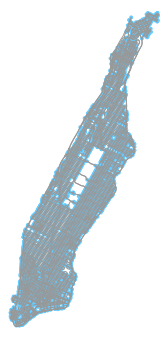

(<matplotlib.figure.Figure at 0x11c6bc748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c6bc1d0>)

In [57]:
import osmnx as ox
%matplotlib inline

G = ox.graph_from_place('Manhattan Island, New York City, New York, USA', network_type='drive')
ox.plot_graph(ox.project_graph(G))

In [58]:
nyc = ox.graph_from_place('New York City, New York, USA', network_type='drive')

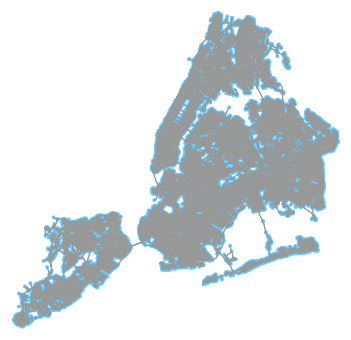

(<matplotlib.figure.Figure at 0x1a5c6849b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a5c6842b0>)

In [59]:
ox.plot_graph(ox.project_graph(nyc))